In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import cv2
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [34]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.9),
        transforms.ColorJitter(brightness=1.1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    ,
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


data_dir = r'/kaggle/input/dataset-drowsiness-20193134/Dataset_drowsiness_1'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


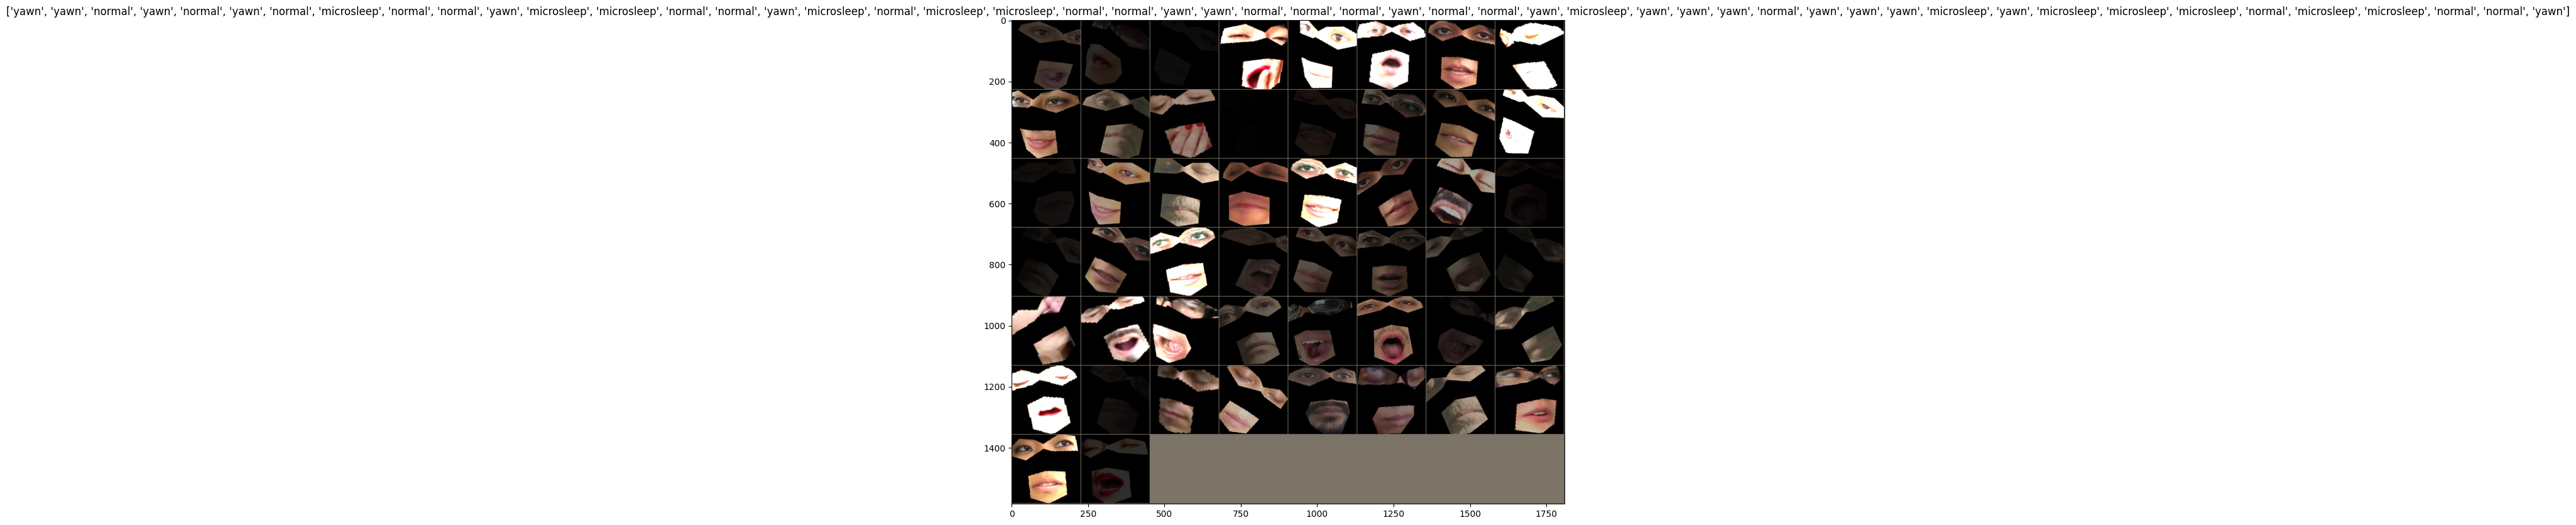

In [35]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.0001)  # pause a bit so that plots are updated
    
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:50])

# Display the images
plt.figure(figsize=(20, 10))
imshow(out, title=[class_names[x] for x in classes[:50]])
plt.show()

In [36]:
best_acc = 0.0
loss0 = 1.0
print(f'Class:{class_names}')
print(f'device:{device}')
print(dataset_sizes)

Class:['microsleep', 'normal', 'yawn']
device:cuda:0
{'train': 46580, 'val': 4500, 'test': 3000}


In [37]:
!mkdir output

mkdir: cannot create directory 'output': File exists


In [38]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=100,output_dir="/kaggle/working/"):
    since = time.time()
    global best_acc
    global loss0
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join('/kaggle/working/output', 'best_model_params.pt')
        last_model_params_path = os.path.join('/kaggle/working/output', 'last_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        
        
        # Lists to store training history
        train_loss_history = []
        train_acc_history = []
        val_loss_history = []
        val_acc_history = []
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
#                         with autocast():
#                             outputs = model(inputs)
#                             loss = criterion(outputs, labels)
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
#                             scaler.scale(loss).backward()
#                             scaler.step(optimizer)
#                             scaler.update()
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # Save history for plotting
                if phase == 'train':
                    train_loss_history.append(epoch_loss)
                    train_acc_history.append(epoch_acc)
                else:
                    val_loss_history.append(epoch_loss)
                    val_acc_history.append(epoch_acc)
                    
                # deep copy the model
                if phase == 'val' and epoch_acc >= best_acc:
                    best_acc = epoch_acc
                    if epoch_acc == best_acc:
                        if epoch_loss < loss0:
                            loss0 = epoch_loss
                            torch.save(model.state_dict(), best_model_params_path)
                    else:
                        torch.save(model.state_dict(), best_model_params_path)
                
                
            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        torch.save(model.state_dict(), last_model_params_path)
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
        
        #plot lossses and accuracy
#         plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history, "/kaggle/working/output")
        train_loss_cpu = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in train_loss_history]
        val_loss_cpu = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in val_loss_history]
        train_acc_cpu = [acc.item() if isinstance(acc, torch.Tensor) else acc for acc in train_acc_history]
        val_acc_cpu = [acc.item() if isinstance(acc, torch.Tensor) else acc for acc in val_acc_history]

        # Vẽ biểu đồ Loss và Accuracy
        def plot(title, ylabel, train_data, val_data, filename):
            plt.figure(figsize=(10, 5))
            plt.plot(train_data, label='Training')
            plt.plot(val_data, label='Validation')
            plt.title(title)
            plt.xlabel('Epoch')
            plt.ylabel(ylabel)
            plt.legend()
            plt.savefig(os.path.join(output_dir, filename))
            plt.show()
        # Vẽ biểu đồ Loss
        plot('Training and Validation Loss', 'Loss', train_loss_cpu, val_loss_cpu, 'Loss.png')
        # Vẽ biểu đồ Accuracy
        plot('Training and Validation Accuracy', 'Accuracy', train_acc_cpu, val_acc_cpu, 'Accuracy.png')
    return model

In [39]:
best_acc

0.0

In [40]:
model_ft = models.mobilenet_v3_small(pretrained=True)
num_ftrs = model_ft.classifier[0].in_features

model_ft.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, num_ftrs),
    nn.BatchNorm1d(num_ftrs),
    nn.ReLU(),
    nn.Linear(num_ftrs, 2000),
    nn.BatchNorm1d(2000),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(2000, 1000),
    nn.BatchNorm1d(1000),
    nn.ReLU(),
    nn.Linear(1000, 3)
)

print(model_ft)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0002)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.005, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/49
----------
train Loss: 0.2105 Acc: 0.9163
val Loss: 0.2862 Acc: 0.8976

Epoch 1/49
----------
train Loss: 0.0795 Acc: 0.9706
val Loss: 0.0579 Acc: 0.9784

Epoch 2/49
----------
train Loss: 0.0611 Acc: 0.9769
val Loss: 0.0377 Acc: 0.9880

Epoch 3/49
----------
train Loss: 0.0500 Acc: 0.9816
val Loss: 0.0467 Acc: 0.9851

Epoch 4/49
----------
train Loss: 0.0444 Acc: 0.9834
val Loss: 0.0538 Acc: 0.9833

Epoch 5/49
----------
train Loss: 0.0431 Acc: 0.9841
val Loss: 0.0239 Acc: 0.9931

Epoch 6/49
----------
train Loss: 0.0382 Acc: 0.9852
val Loss: 0.0741 Acc: 0.9787

Epoch 7/49
----------
train Loss: 0.0318 Acc: 0.9880
val Loss: 0.0170 Acc: 0.9951

Epoch 8/49
----------
train Loss: 0.0326 Acc: 0.9877
val Loss: 0.0179 Acc: 0.9956

Epoch 9/49
----------
train Loss: 0.0313 Acc: 0.9875
val Loss: 0.0170 Acc: 0.9949

Epoch 10/49
----------
train Loss: 0.0298 Acc: 0.9884
val Loss: 0.0178 Acc: 0.9951

Epoch 11/49
----------
train Loss: 0.0290 Acc: 0.9887
val Loss: 0.0176 Acc: 0.9947

Ep

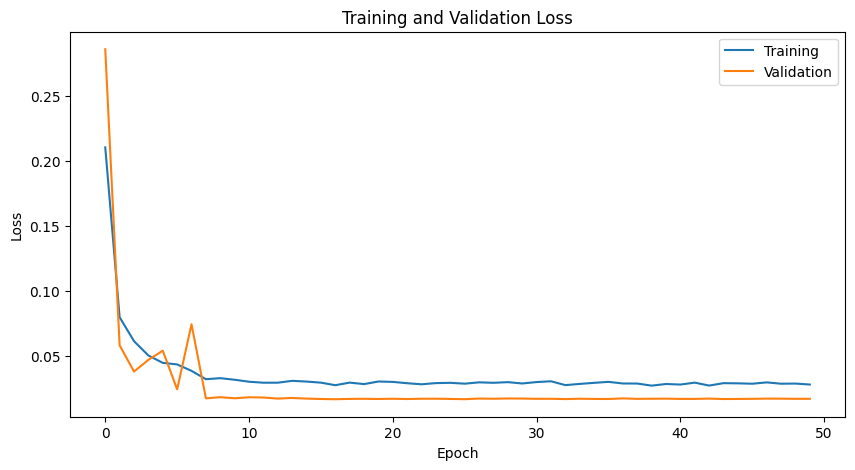

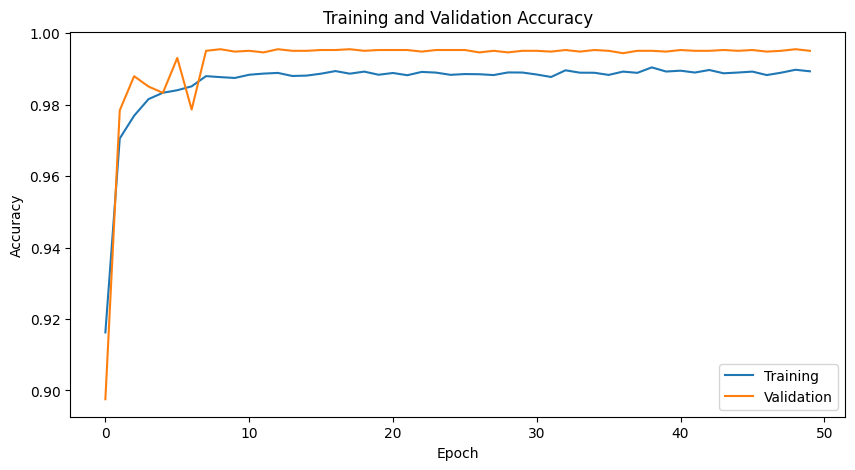

In [41]:
model_ft= train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

In [42]:
best_model = models.mobilenet_v3_small(pretrained=True)
num_ftrs = best_model.classifier[0].in_features
best_model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, num_ftrs),
    nn.BatchNorm1d(num_ftrs),
    nn.ReLU(),
    nn.Linear(num_ftrs, 2000),
    nn.BatchNorm1d(2000),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(2000, 1000),
    nn.BatchNorm1d(1000),
    nn.ReLU(),
    nn.Linear(1000, 3)
)

print(best_model)
best_model.load_state_dict(torch.load(r'/kaggle/working/output/best_model_params.pt', map_location=torch.device('cpu')))
best_model = best_model.to(device)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

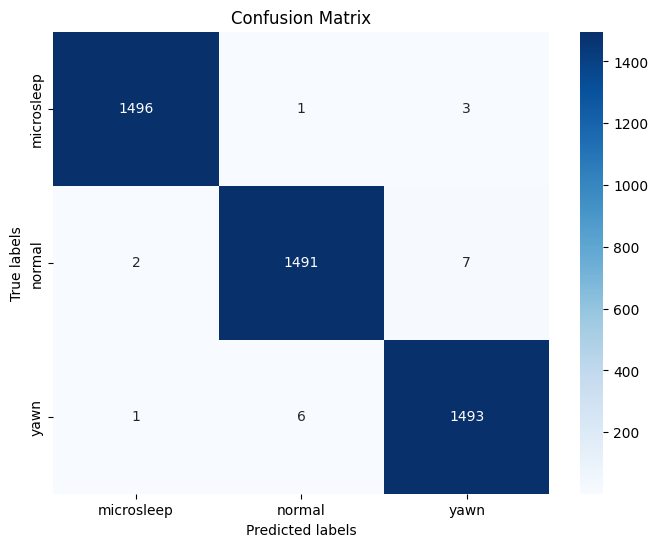

              precision    recall  f1-score   support

  microsleep    0.99800   0.99733   0.99767      1500
      normal    0.99533   0.99400   0.99466      1500
        yawn    0.99335   0.99533   0.99434      1500

    accuracy                        0.99556      4500
   macro avg    0.99556   0.99556   0.99556      4500
weighted avg    0.99556   0.99556   0.99556      4500



In [43]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".5g", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=5)
    return report

# Example usage
val_report = evaluate_model(best_model, dataloaders['val'], device)
print(val_report)


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


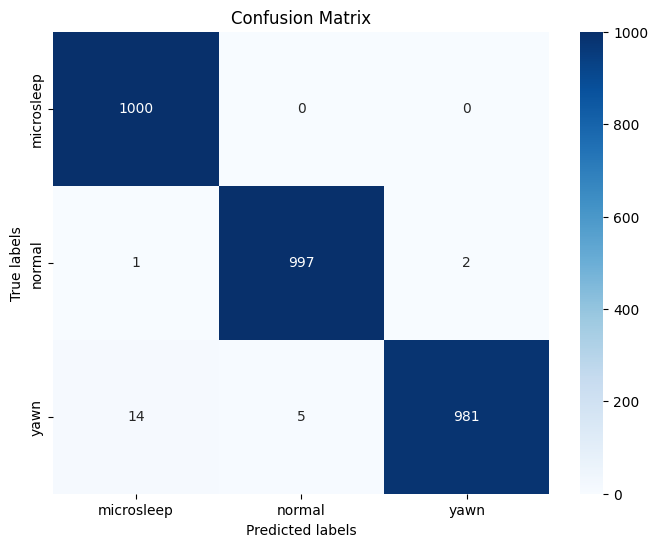

              precision    recall  f1-score   support

  microsleep    0.98522   1.00000   0.99256      1000
      normal    0.99501   0.99700   0.99600      1000
        yawn    0.99797   0.98100   0.98941      1000

    accuracy                        0.99267      3000
   macro avg    0.99273   0.99267   0.99266      3000
weighted avg    0.99273   0.99267   0.99266      3000



In [44]:
test_report = evaluate_model(best_model, dataloaders['test'], device)
print(test_report)


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


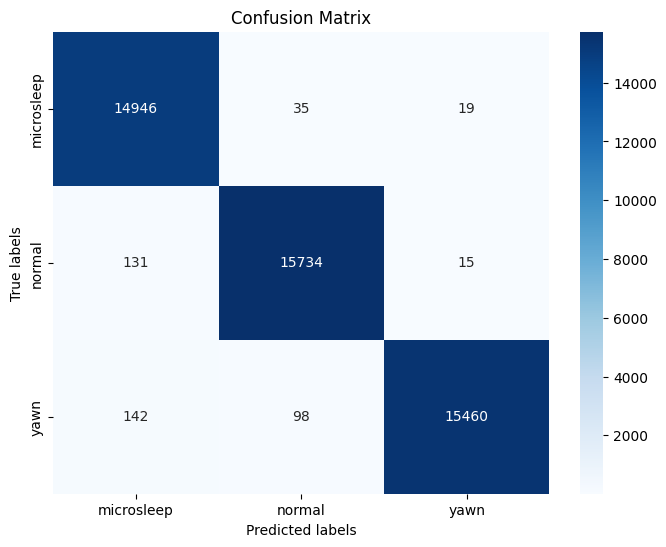

              precision    recall  f1-score   support

  microsleep    0.98206   0.99640   0.98918     15000
      normal    0.99162   0.99081   0.99121     15880
        yawn    0.99781   0.98471   0.99122     15700

    accuracy                        0.99055     46580
   macro avg    0.99050   0.99064   0.99054     46580
weighted avg    0.99063   0.99055   0.99056     46580



In [45]:
train_report = evaluate_model(best_model, dataloaders['train'], device)
print(train_report)
